In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
from time import time
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.image as mpimg
%matplotlib inline
from matplotlib import pyplot as plt

# Eigenvalues and eigenvectors

There are several ways to find eigenvalues and eigenvectors of matrices in python.

###  For dense (or sparse) matrices, that are not too large, where you want all eigenvalues:
* For both eigenvalues and eigenvectors,  look at `np.linalg.eig` and `np.linalg.eigh`.
* For eigenvalues only, look at `np.linalg.eigvals` and `np.linalg.eigvalsh`.

https://numpy.org/doc/stable/reference/routines.linalg.html#matrix-eigenvalues


### For large, sparse matrices:
There are iterative methods that allow you to find only some number of eigenvectors, e.g., the $n$ largest.
* Have a look at `scpiy.parse.linalg.eigs` and `scpiy.parse.linalg.eigsh` (which wraps the Fortran library ARPACK)
* See also notes on the slides.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html


## General recommendation:
It is useful to look into how these methods work, and even to try implementing one yourself, but for any application where you care about performance, it is easier, and almost surely more efficient to use a preexisting library.

In [2]:
# Function for creating a test matrix
# Larger tau makes the matrix more difficult to solve

def getA(N, tau):
    # Construct test matrix according to
    # Trefethen, Numerical Linear Algebra, page 300
    # Insert random elements such that A is symmetric
    r = 2*np.random.random((N, N)) - 1
    A = np.tril(r, k = -1) + np.tril(r, k = -1).T
    # Set all elements with abs larger than tau to 0
    A = np.where(abs(A) > tau, 0, A)
    # And add ones on diagonal
    A += np.identity(N)
    return A

np.linalg.eig took 0.4694 seconds
np.linalg.eigh took 0.0859 seconds
np.linalg.eigvals took 0.3142 seconds
np.linalg.eigvalsh took 0.0384 seconds


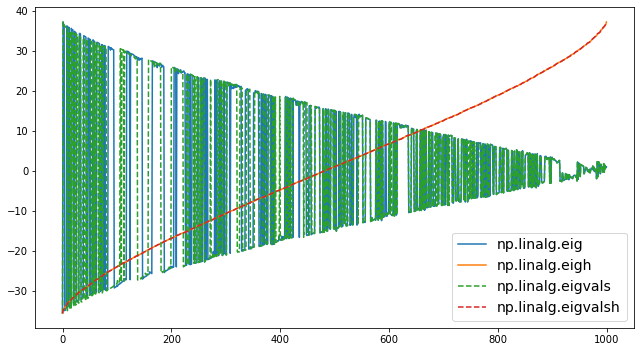

In [3]:
A = getA(1000, 1)
fig = plt.figure(figsize = (9, 5))

# Note: np.linalg.eig returns _unsorted_ eigenvalues,
# with the eigenvectors in the same order as the eigenvalues
tic = time()
eigvals, eigvecs = np.linalg.eig(A)
toc = time()
print(f'np.linalg.eig took {toc - tic:.4f} seconds')
plt.plot(eigvals, label = 'np.linalg.eig')


# If the matrix is symmetric (or conjugate symetric if complex),
# np.linalg.eigh is a bit faster
# Note: np.linalg.eigh returns _sorted_ eigenvalues,
# with the eigenvectors in the same order as the eigenvalues
tic = time()
eigvals, eigvecs = np.linalg.eigh(A)
toc = time()
print(f'np.linalg.eigh took {toc - tic:.4f} seconds')
plt.plot(eigvals, label = 'np.linalg.eigh')


# If you need only the eigenvalues, not the eigenvectors,
# there are functions for that:

tic = time()
eigvals = np.linalg.eigvals(A)
toc = time()
print(f'np.linalg.eigvals took {toc - tic:.4f} seconds')
plt.plot(eigvals, '--', label = 'np.linalg.eigvals')

tic = time()
eigvals = np.linalg.eigvalsh(A)
toc = time()
print(f'np.linalg.eigvalsh took {toc - tic:.4f} seconds')
plt.plot(eigvals, '--', label = 'np.linalg.eigvalsh')

plt.legend(fontsize = 14)
plt.tight_layout()

# Example: Power iterations

Power iterations is a way to find the largest eigenvalue of a matrix. In practice, there might be better approaches, but it is quite an instructive example to consider, so we will have a closer look.

Assume first that we have a matrix $\mathbf{A}$, and an eigenvector $\mathbf{v}$. Then, by definition:
$$ \mathbf{A} \mathbf{v} = \lambda \mathbf{v}, $$
where $\lambda$ is the eigenvalue corresponding to that eigenvector.

Next, assume that we have some other vector, $\mathbf{x}$, which is a linear combination of _all_ the eigenvectors of $\mathbf{A}$, i.e.,
$$ \mathbf{x} = \sum_{i=1}^N c_i \mathbf{v}_i, $$
where $c_i$ are some unknown coefficients.

Calculating the product $\mathbf{A}\mathbf{x}$ will "stretch" the vector $\mathbf{x}$ in different directions. Again, by definition of eigenvectors and eigenvalues:
$$ \mathbf{A}\mathbf{x} = \sum_{i=1}^N \lambda_i c_i \mathbf{v}_i. $$

And if we multiply by $\mathbf{A}$ $n$ times, we similarly have
$$ \mathbf{A}^n\mathbf{x} = \sum_{i=1}^N \lambda_i^n c_i \mathbf{v}_i. $$

Hence, we see that the part of the vector $\mathbf{x}$ that points along the eigenvector associated with the largest eigenvalue, will grow faster than all the other components. Eventually, we are left with a vector that points only in that direction, and the change from one iteration to the next will then give us the largest eigenvalue.

Note: Since all we need is the matrix-vector product, this is suited for large sparse matrices.

In [4]:
from scipy.sparse.linalg import LinearOperator

In [5]:
def power_iteration(Adot, maxiter = 1000, tol = 1e-3):
    # Note: dot is not the matrix itself,
    # but a LinearOperator Adot(x) that returns A.dot(x)
    # The reason for this will become clear later.
    
    # Start with a random vector. It is quite unlikely that this
    # will be exactly orthogonal to the desired eigenvector
    b0 = np.random.rand(Adot.shape[1])
    # normalise vector
    b0 = b0 / np.linalg.norm(b0)
    
    for i in range(maxiter):
        # Calculate product
        b1 = Adot(b0)
        # Calculate "stretch" factor
        b1_norm = np.linalg.norm(b1)
        # Normalise vector
        b1 = b1 / b1_norm
        # check for convergence
        if np.linalg.norm(b1 - b0) < tol:
            return b1_norm, b1, 0
        else:
            # Continue iterations
            b0 = b1
    # If we arrived here, iterations did not converge
    return b1_norm, b1, 1

In [6]:
A = getA(1000, 1)
Adot = LinearOperator(A.shape, lambda x: A.dot(x))

eigval, eigvec, info = power_iteration(Adot)
assert info == 0

print(f'Largest eigenvalue found by power iterations:   {eigval:.6f}')
print(f'Largest eigenvalue found by np.linalg.eigvalsh: {np.linalg.eigh(A)[0][-1]:.6f}')

Largest eigenvalue found by power iterations:   36.998326
Largest eigenvalue found by np.linalg.eigvalsh: 37.001611


In [7]:
%timeit eigval, eigvec, info = power_iteration(Adot)
%timeit eigval, eigvec = np.linalg.eigh(A)

45 ms ± 4.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
61.9 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Example: Finding the smallest eigenvalue with power iteration

We can also use the method of power iterations to find the smallest eigenvalue. The trick then is that instead of finding the smallest eigenvalue of $\mathbf{A}$, we find the largest eigenvalue of $\mathbf{A}^{-1}$. And, since all we need is to be able to calculate $\mathbf{x}' = \mathbf{A}^{-1} \mathbf{x}$, we do not need to explicitly find $\mathbf{A}^{-1}$, we can instead just solve the equation
$$ \mathbf{A} \mathbf{x}' = \mathbf{x}. $$

In [8]:
from scipy.sparse.linalg import bicgstab

In [9]:
A = getA(200, 1)

# Construct a linear operator that will return A^{-1} x
Adot = LinearOperator(A.shape, lambda x: bicgstab(A, x, x0 = x)[0])

eigval, eigvec, info = power_iteration(Adot)
#assert info == 0

print(f'Largest eigenvalue found by power iterations:   {1/eigval:.6f}')
print(f'Largest eigenvalue found by np.linalg.eigvalsh: {np.amin(np.abs(np.linalg.eigh(A)[0])):.6f}')

Largest eigenvalue found by power iterations:   0.058043
Largest eigenvalue found by np.linalg.eigvalsh: 0.058043


# SVD (Singular Value Decomposition)

The SVD of an $M \times N$ matrix $\mathbf{A}$ is a decomposition that allows us to write

$$ \mathbf{A} = \mathbf{U}\mathbf{S}\mathbf{V}^\dagger, $$

where $\mathbf{U}$ is an $M \times M$ matrix, $\mathbf{S}$ is a real, diagonal $M \times N$ matrix, and $\mathbf{V}$ is an $N \times N$ matrix. If $\mathbf{A}$ is real, then also $\mathbf{U}$ and $\mathbf{V}$ are real, and $\mathbf{V}^\dagger = \mathbf{V}^T$.

* The columns of the matrix $\mathbf{U}$ are called the left singular vectors of $\mathbf{A}$, and are also the eigenvectors of the matrix $\mathbf{A}\mathbf{A}^\dagger$.
* The diagonal elements of the matrix $\mathbf{S}$ are called the singular values of $\mathbf{A}$. Since $\mathbf{S}$ is diagonal, all off-diagonal elements are zero. We also have $S_{ii} = \sqrt{\lambda_i}$, where $\lambda_i$ is the $i$th eigenvalue of $\mathbf{A}$.
* The columns of the matrix $\mathbf{V}$ are called the right singular vectors of $\mathbf{A}$, and are also the eigenvectors of the matrix $\mathbf{A}^\dagger \mathbf{A}$.

The SVD has a wide range of applications. Here, we will only look at a few different examples, and try to build some intuition.

## Example 1: Find the axes of an elliptical point cloud in 2D

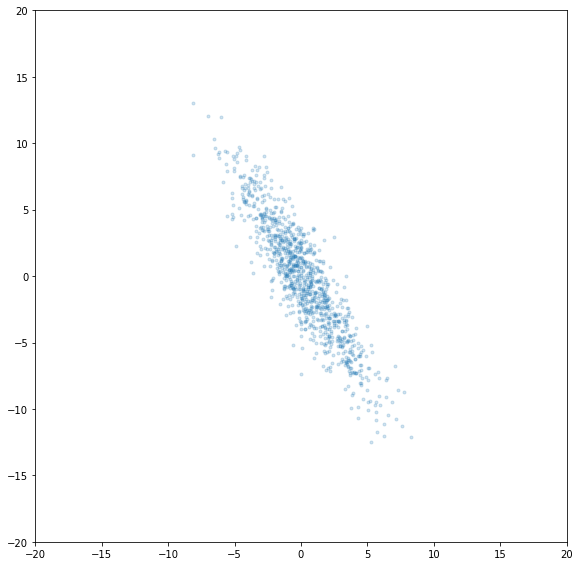

In [10]:
## An example of using SVD to determine the principal directions
## of a cloud of random points in two dimensions

# Two unit vectors, pointing at 30 degrees and 120 degrees
# counter-clockwise from the positive x axis:
x0 = np.array([np.sqrt(3)/2, 1.0/2])
x1 = np.array([-1.0/2, np.sqrt(3)/2])

# Create an "elliptical" distribution of Gaussian random numbers,
# with sigma = 1 along x0 and sigma = 5 along x1:
N = 1000
R = np.random.normal(loc = 0, scale = 1, size = N)*x0[:,None] \
    + np.random.normal(loc = 0, scale = 5, size = N)*x1[:,None]

# Equivalent, but perhaps less readable:
#R = (np.random.normal(loc = 0, scale = 1, size = (N, 2)) @ np.array((x0, 5*x1))).T

# Plot the cloud of points
fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(111, aspect = 'equal') # use aspect equal to preserve shape
plt.scatter(R[0,:], R[1,:], marker = '.', alpha = 0.2)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.tight_layout()

Left singular vectors:
[[-0.49910554  0.8665412 ]
 [ 0.8665412   0.49910554]]

Singular values: [153.78131052  31.44183553]


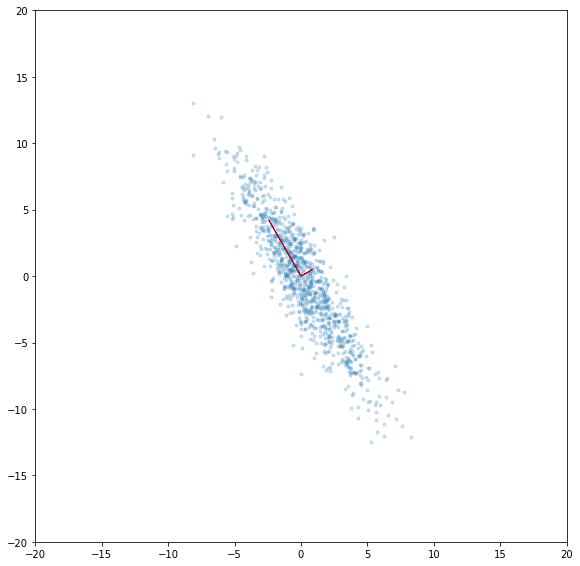

In [11]:
# Take the SVD of R
U, S, V = np.linalg.svd(R)

print('Left singular vectors:')
print(U)
print()
print('Singular values:', S)

# Plot the point cloud
fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(111, aspect = 'equal') # use aspect equal to preserve shape
plt.scatter(R[0,:], R[1,:], marker = '.', alpha = 0.2)

# Plot the two left singular vectors given by U, scaled by the corresponding
# singular value.
c = 1/np.sqrt(N)
for i in range(2):
    plt.arrow(0, 0, c*S[i]*U[0,i], c*S[i]*U[1,i], color = '#A60628')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.tight_layout()

## Reconstructing the matrix

We can reconstruct the matrix, from the definition

$$ \mathbf{A} = \mathbf{U}\mathbf{S}\mathbf{V}^\dagger $$

or written out more explicitly:

$$ \mathbf{A}_{ij} = \sum_{k=1}^N \mathbf{U}_{ik} \mathbf{S}_{kk} \mathbf{V}^\dagger_{kj} $$

Each term in this sum is a matrix (given by the outer product of the $k$th column of $\mathbf{U}$ and the $k$th row of $\mathbf{V}$) multiplied by the $k$th singular value. If we truncate the sum after including only a few terms, corresponding to the largest singular values, we have an approximation of the matrix.

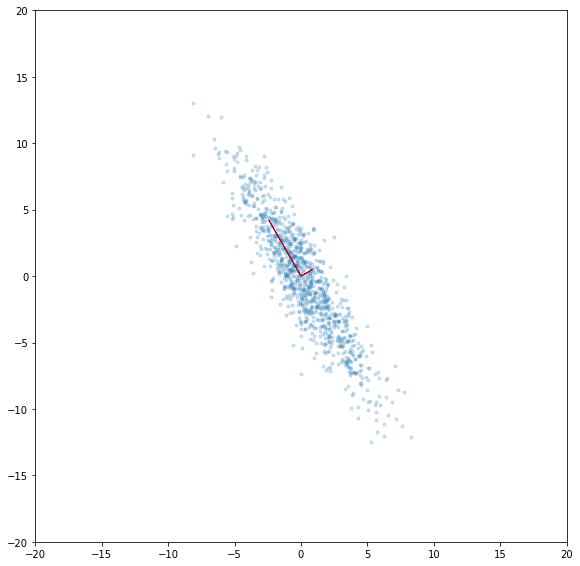

In [12]:
n = 2
# This line implements the sum above, truncated at n
# (note that n <= N, and N = 2 in this case)
Rn = (U[:,:n] @ (S[:n,None]*V[:n,:]))

# Plot the point cloud
fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(111, aspect = 'equal') # use aspect equal to preserve shape
plt.scatter(Rn[0,:], Rn[1,:], marker = '.', alpha = 0.2)

# Plot the two left singular vectors given by U, scaled by the corresponding
# singular value.
c = 1/np.sqrt(N)
for i in range(2):
    plt.arrow(0, 0, c*S[i]*U[0,i], c*S[i]*U[1,i], color = '#A60628')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.tight_layout()

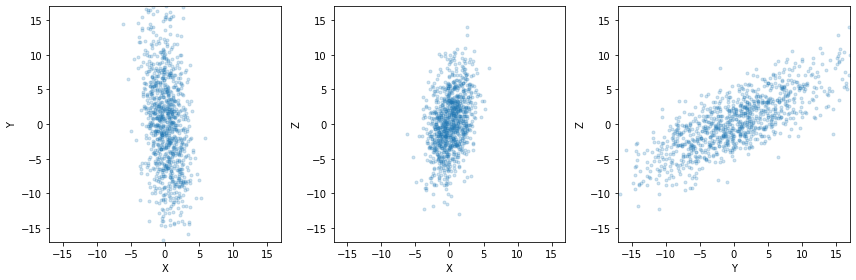

In [13]:
## An example of using SVD to determine the principal directions
## of a cloud of random points in four dimensions

# Three unit vectors
x0 = np.array([1/np.sqrt(3), -1/np.sqrt(3), 1/np.sqrt(3)])
x1 = np.array([0, np.sqrt(3)/2, 1/2])
x2 = np.array([0,  1.0/2, np.sqrt(3)/2])

# Create an "elliptical" distribution of Gaussian random numbers,
# with sigma = 1 along x0 and sigma = 5 along x1 and sigma = 0.1 along x2
R = (np.random.normal(loc = 0, scale = 1, size = (N, 3)) @ np.array((3*x0, 8*x1, 0.01*x2))).T

# Plot the cloud of points
fig, ax = plt.subplots(ncols = 3, figsize = (12, 4))
ax[0].scatter(R[0,:], R[1,:], marker = '.', alpha = 0.2)
ax[1].scatter(R[0,:], R[2,:], marker = '.', alpha = 0.2)
ax[2].scatter(R[1,:], R[2,:], marker = '.', alpha = 0.2)

ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Z')
ax[2].set_xlabel('Y')
ax[2].set_ylabel('Z')

for a in ax:
    a.set_xlim(-17, 17)
    a.set_ylim(-17, 17)
plt.tight_layout()

Left singular vectors:
[[-0.03847415 -0.58945287 -0.80688602]
 [ 0.8904601   0.34618589 -0.29535766]
 [ 0.45343198 -0.72986344  0.51156505]]

Singular values: [2.50411403e+02 9.19320551e+01 9.35007755e-02]


<IPython.core.display.Javascript object>


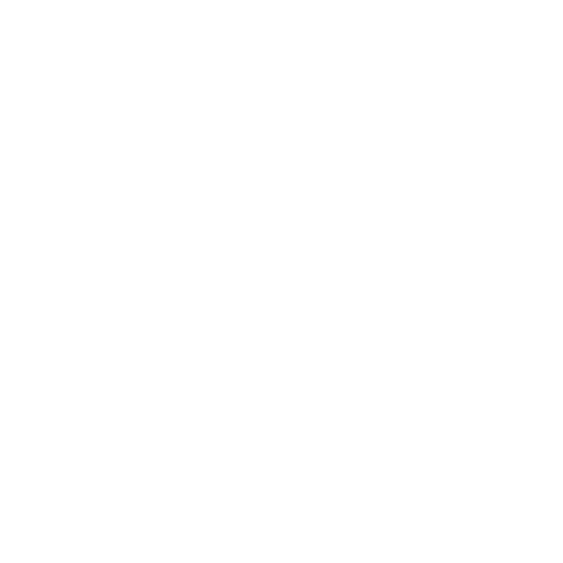

In [14]:
# Take the SVD of R
U, S, V = np.linalg.svd(R)

print('Left singular vectors:')
print(U)
print()
print('Singular values:', S)

# Set up 3D plot
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (6,6))

ax1 = fig.add_subplot(111, projection='3d') # Note: 3D plot doesn't support aspect = 'equal'
ax1.scatter(R[0,:], R[1,:], R[2,:], s = 1, marker = '.')

# Plot the two left singular vectors given by U, scaled by the corresponding
# singular value.
c = 1/np.sqrt(N)
for i in range(3):
    ax1.plot((0, c*S[i]*U[0,i]), (0, c*S[i]*U[1,i]), (0, c*S[i]*U[2,i]), color = '#A60628')

## PCA - Principal Component Analysis

Text(0, 0.5, 'PC 2')

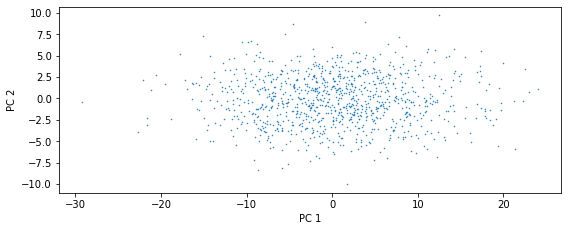

In [15]:
%matplotlib inline
# Plot projection onto the plane spanned by the first two left singular vectors
x = np.dot(U[:,0], R)
y = np.dot(U[:,1], R)

fig = plt.figure(figsize = (9, 6))
ax  = fig.add_subplot(111, aspect = 'equal') # use aspect equal to preserve shape
plt.scatter(x, y, s = 1, marker = '.')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

(1, 1000)
[-1.47649491]


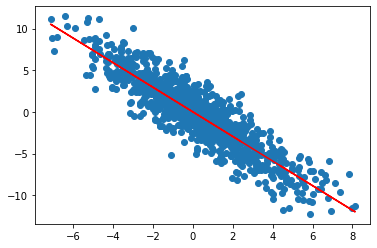

In [16]:
# least squares via SVD with pseudoinverse
from numpy.linalg import pinv

# Two unit vectors, pointing at 30 degrees and 120 degrees
# counter-clockwise from the positive x axis:
x0 = np.array([np.sqrt(3)/2, 1.0/2])
x1 = np.array([-1.0/2, np.sqrt(3)/2])

# Create an "elliptical" distribution of Gaussian random numbers,
# with sigma = 1 along a and sigma = 5 along b:
N = 1000
R = (np.random.normal(loc = 0, scale = 1, size = N)*x0[:,None] \
    + np.random.normal(loc = 0, scale = 5, size = N)*x1[:,None]).T

X, y = R[:,0], R[:,1]
X = X.reshape((len(X), 1))
# calculate coefficients

print(pinv(X).shape)
b = pinv(X).dot(y)
print(b)
# predict using coefficients
yhat = X.dot(b)
# plot data and predictions
plt.scatter(X, y)
plt.plot(X, yhat, color='red')


## Linear regression with SVD

Say we have $N$ points in the $xy$-plane, $(x_i, y_i)$ for $i = 1\ldots N$. We then want to find a linear expression of the form $b_1 x_i + b_2 = y_i$, which approximates all the points in the best way. This can be written as a matrix equation:

$$ \left[ \begin{array}{cc} x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_N & 1 \end{array} \right]
\left[ \begin{array}{c} b_1 \\ b_2  \end{array} \right]
=
\left[ \begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_N \end{array} \right].$$

$$ \mathbf{X}\mathbf{b} = \mathbf{y} $$

This is a system with $N$ equations, and only 2 unknows: the coefficients $b_1$ and $b_2$. In general, this equation is *overdetermined*, and does not have a solution (unless *all* the points $(x_i, y_i)$ happen to lie on a straight line).

The matrix $\mathbf{X}$ does not have an inverse (only square matrices do). However we can find the solution that gives the best approximation, by finding the *pseudoinverse* of $\mathbf{X}$. We can find this from the SVD. If the SVD of $\mathbf{X}$ is given by

$$ \mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^\dagger, $$

then the pseudoinverse, $\mathbf{X}^+$, is given by

$$ \mathbf{X}^+ = \mathbf{V}\mathbf{S}^+ \mathbf{U}^\dagger, $$

where the pseudoinverse $\mathbf{S}^+$ of the diagonal matrix $\mathbf{S}$ is given by

$$ \mathbf{S}^+_{ii} = \left\{ \begin{array}{ccc} \frac{1}{\mathbf{S}_{ii}} & \mathrm{if} & \mathbf{S}_{ii} \neq 0 \\ 0 & \mathrm{if} & \mathbf{S}_{ii} = 0 \end{array}\right., $$

(and all the off-diagonal elements of $\mathbf{S}^+$ are zero).

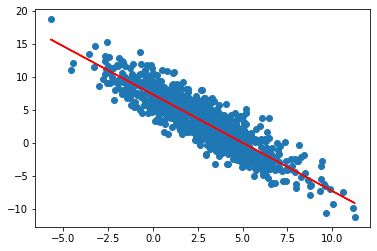

In [17]:
# Two unit vectors, pointing at 30 degrees and 120 degrees
# counter-clockwise from the positive x axis:
x0 = np.array([np.sqrt(3)/2, 1.0/2])
x1 = np.array([-1.0/2, np.sqrt(3)/2])

# Create an "elliptical" distribution of Gaussian random numbers,
# with sigma = 1 along a and sigma = 5 along b, and a nonzero mean:
N = 1000
R = (np.random.normal(loc = 4, scale = 1, size = N)*x0[:,None] \
    + np.random.normal(loc = 2, scale = 5, size = N)*x1[:,None]).T

# Set up the matrix X and the vector y, as seen above
X = np.ones((N, 2))
X[:,0] = R[:,0]
y = R[:,1]

# Find the pseudoinverse of X from the SVD
U, S, V = np.linalg.svd(X)
# Convert S from a vector to a diagonal matrix,
# and take the inverse of the non-zero elements
Sinv = np.zeros((2, N))
Sinv[:,:2] = np.diag(np.where(S != 0, 1/S, S))
Xinv = (V.T @ Sinv @ U.T)

# Calculate coefficients b
b = np.dot(Xinv, y)

# predict using coefficients
yhat = X.dot(b)
# plot data and predictions
plt.scatter(X[:,0], y)
plt.plot(X[:,0], yhat, color='red')


In [18]:
# Find the pseudoinverse of X from the SVD
U, S, V = np.linalg.svd(X)
Sinv = np.zeros((2, N))
Sinv[:,:2] = np.diag(np.where(S != 0, 1/S, S))
Xinv1 = (V.T @ Sinv @ U.T)

# Find the pseudoinverse directly with numpy.linalg.pinv
Xinv2 = np.linalg.pinv(X)

# Confirm that the results are the same
np.allclose(Xinv1, Xinv2)

True

# Applying SVD to an image

An image is just a matrix, or actually three (RBG) or four matrices (RGBa) in the case of colour images.

As we saw above, we can reconstruct a matrix using only the first few singular values/vectors, and get a reasonable approximation of the original matrix. Here we illustrate this by applying it to a photo.

img.shape =  (756, 756, 4)


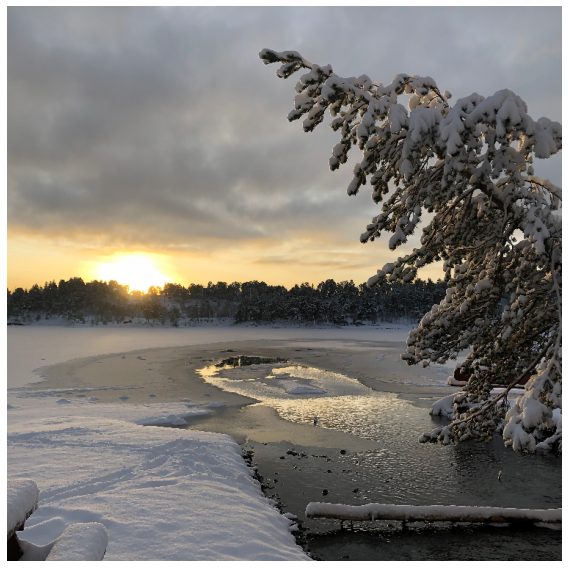

In [19]:
# load an image
img=mpimg.imread('../files/lake_and_tree.png')
plt.figure(figsize = (8,8))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()

print('img.shape = ', img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


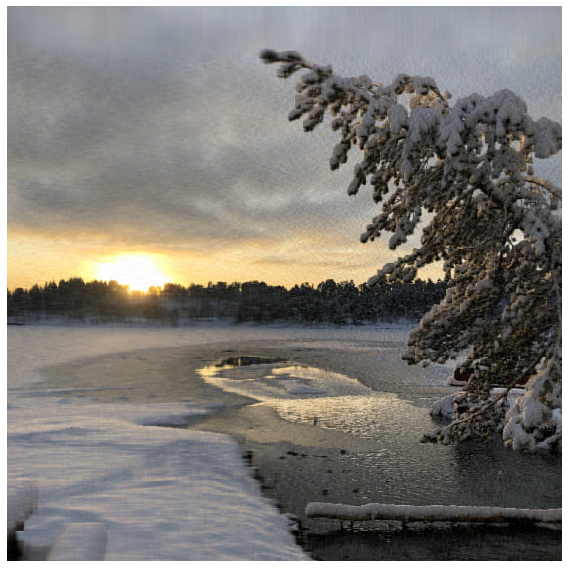

In [20]:
# Take the SVD
img=mpimg.imread('../files/lake_and_tree.png')
U, S, V = np.linalg.svd(img.T)

# Reconstruct using only first N singular values/vectors
N = 100

plt.figure(figsize = (8,8))
plt.imshow((U[:,:,:N] @ (S[:,:N,None]*V[:,:N,:])).T)
plt.axis('off')
plt.tight_layout()

In [21]:
from ipywidgets import interact, IntSlider
%matplotlib notebook

<IPython.core.display.Javascript object>


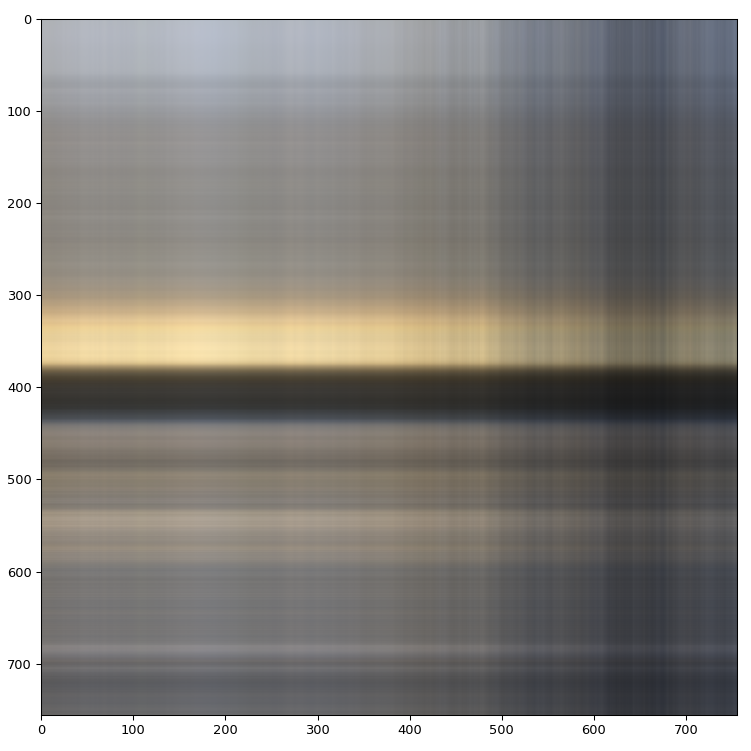

In [22]:
img=mpimg.imread('../files/lake_and_tree.png')
U, S, V = np.linalg.svd(img.T)
fig = plt.figure(figsize = (8,8))

def svd_plotter(n):
    plt.imshow((U[:,:,:n] @ (S[:,:n,None]*V[:,:n,:])).T)
    plt.tight_layout()

In [23]:
slider = interact(svd_plotter, n = IntSlider(min=1, max=756, step=1, continuous_update = False))

interactive(children=(IntSlider(value=1, continuous_update=False, description='n', max=756, min=1), Output()),…